In this notebook we'll go through the process of training and optimising a classifier for detecting heart diease in patients.

In [1]:
import os.path

import pandas as pd
from pandas.plotting import scatter_matrix

from itertools import combinations

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.metrics import (auc, roc_auc_score, precision_recall_curve, 
                             roc_curve,precision_score, accuracy_score, recall_score, make_scorer)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn import clone
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,cross_validate, 
                                     train_test_split, cross_val_score, cross_val_predict, 
                                     StratifiedShuffleSplit)
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.manifold import LocallyLinearEmbedding

from scikitplot.classifiers import plot_precision_recall_curve_with_cv


import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

import pickle

from scipy.stats import mode
from scipy.stats import uniform, norm, randint

import eli5
from eli5.sklearn import PermutationImportance

from itertools import combinations

import seaborn as sns

#My own modules
from data_prep import *
from model_selection import *
from visualisation import *

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
# pd.options.mode.chained_assignment = None
style.use('ggplot')

#For reproducibility
random_state = 250
np.random.seed(250)

c:\users\brend\python\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\brend\python\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
img_path = r'images'

# Data exploration

All data exploration and visulalisation has already been completed in the other notebook. Here will will just import the data and do the same transformations to the data.

In [3]:
df = pd.read_excel(r'datasets\heart.xlsx')
#Change target vector so that 1 = heart disease, 0 = no heart disease.
df['target'].replace([0,1], [1,0], inplace = True)
#Remove any duplicate rows
df.drop(df[df.duplicated(keep = 'first')].index[0], inplace = True)
#Change the column names to be more descriptive
df = rename_columns(df)
df.head()

,age,sex,chest pain type,resting blood pressure,cholesterol,fasting blood sugar > 120 mg/dl,rest ecg results,max heart rate,exercise induced angina,ST depression (ecg),slope of peak ST (ecg),major vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


We will reiterate the explanation of the variables here.

* Chest pain type: 0 = asymptomatic, 1 = atypical angina, 2 = non-anginal pain,3= asymptomatic.
* Fasting blood sugar: 1 = fasting blood sugar > 120 mg/dl, 0 = otherwise.
* Rest ecg result: 0 = left ventricular hypertrophy, 1= normal, 2 = abnormal
* ST depression (ecg) and slope of peak ST (ecg): These are both based on the patients electrocardiogram (ecg) reults. The first feature is the ST depression induced by exercise relative to rest. The second is the slope of the peak exercise ST segment, 0 = downsloping, 1 = flat, 2 = upsloping.
* Major vessels: The number of major vessels coloured by fluorosopy, 0-3. According to wikipedia, flouroscopy is ' an imaging technique that ... allows a physician to see the internal structure and function of a patient, so that the pumping action of the heart ... can be watched'.   
* Thalassemia: 1 = fixed defect, 2 = normal, 3 = reversable defect. Thalassemia is a blood disorder that causes your body to have less hemoglobin than normal. We take 'normal' to mean the patient does not have thalassemia. 
* Target: 1 = heart disease, 0 = no heart disease. Note that in the original dataset this seems to be the other way around. Note that 'heart disease' is a broad term, that generally refers to conditions involving narrowed or blocked blood vessels. It's not clear whether all patients with target = 1 are victims of a heart attack/stroke etc.


In [4]:
df['major vessels'].replace([4],[0], inplace = True)
df['thalassemia'].replace([0], [2], inplace = True)

In [5]:
#Splitting fatures into numerial, binary and categorical features
num_features, bin_features, cat_features = separate_num_bin_cat_features(df)

In [6]:
#Reordering the columns
df = df[num_features + bin_features + cat_features + ['target']].copy()

In [7]:
X = df.drop(['target'], axis = 1).copy()
Y = df['target'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size = 0.2, random_state = random_state, 
                                                    stratify = Y) 


# Preparing the data

In [8]:
#We rename the values of the categorical features to improve interpretability later on.
def rename_cat_values(df):
    df['chest pain type'].replace([0,1,2,3],['asymptomatic cp','atypical angina cp','non-anginal cp','typical angina cp'],inplace = True)
    df['rest ecg results'].replace([0,1,2],['left ventricular hypertrophy (ecg)', 'normal ecg', 'abnormal ecg'],inplace = True)
    df['slope of peak ST (ecg)'].replace([0,1,2],['downsloping','flat','upsloping'],inplace = True)
    df['thalassemia'].replace([1,2,3], ['fixed thal','no thal','reversable thal'], inplace = True)
    
 


In [9]:
rename_cat_values(X_train)
rename_cat_values(X_test)
X_train.tail(3)

,age,resting blood pressure,cholesterol,max heart rate,ST depression (ecg),major vessels,sex,exercise induced angina,fasting blood sugar > 120 mg/dl,chest pain type,rest ecg results,slope of peak ST (ecg),thalassemia
12,49,130,266,171,0.6,0,1,0,0,atypical angina cp,normal ecg,upsloping,no thal
180,55,132,353,132,1.2,1,1,1,0,asymptomatic cp,normal ecg,flat,reversable thal
277,57,124,261,141,0.3,0,1,0,0,atypical angina cp,normal ecg,upsloping,reversable thal


We have a pretty even split of numerical and categorical data. We will scale the numerical data so that each of the features has mean 0 and standard deviation 1. The categorical data will be one hot encoded, and we'll leave the binary data alone. This should work fine for all the data except major vessels, where the order of the labels matter. So we'll treat that as numerical data. Also note that for a categorical variable with $n$ labels, we in general need only keep $n-1$ of the corresponding dummy variables, but some models prefer to keep all the variables. For example consider the case of a random forest where each node of every tree considers one feature at a time. Then if we feed this model encoded data where we drop the first dummy variable, then we could have variables for 'reversable thalassemia', and 'fixed thalassemia', but none for 'no thalassemia'. Then the random forest has no way of comparing the cases of someone having thalassemia and not having thalassemia. Keeping all the dummy variables of course has the disadvantage of increasing the dimesion of our feature space and thus increasing computation time, but later on we will use feature selection to drop unimportant features. Another downside is that we will be increasing the colinearity in the data. which can affect some classifiers. Hopefully our feature selection will reduce the effect of this a bit, but there are no guarantees.


In [10]:
X_cat = X_train[cat_features].copy()
one_hot_encoder = OneHotEncoder(categories = 'auto', drop = None)
X_cat_encoded = one_hot_encoder.fit_transform(X_cat)
cat_features_encoded = one_hot_encoder.categories_

In [11]:
encoded_features = num_features + bin_features + [cat_features_encoded[i][j] for i in range(len(cat_features_encoded)) for
                                   j in range(len(cat_features_encoded[i]))]


In [12]:
cat_pipeline = Pipeline([
                ('one_hot', OneHotEncoder(categories = cat_features_encoded, drop = None))
])

num_pipeline = Pipeline([
                ('standardise', StandardScaler())
])

In [13]:
prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('bin', FunctionTransformer(), bin_features),
    ('cat', cat_pipeline, cat_features)
])

In [14]:
X_train_prepped = prep_pipeline.fit_transform(X_train)
X_test_prepped = prep_pipeline.transform(X_test)

In [15]:
#It will later become useful to have the training set where the numerical
#features are unscaled, but the categorical features are one-hot encoded
only_cat_pipeline = ColumnTransformer([
    ('num', FunctionTransformer(), num_features),
    ('bin', FunctionTransformer(), bin_features),
    ('cat', cat_pipeline, cat_features)
])
X_train = only_cat_pipeline.fit_transform(X_train)

# Training  and selecting the models

As with all classification tasks, it is important to use an appropriate metric for evaluating our model. Here we will suppose that our model will be used to determine those patients who should be subject to further tests and examination, so we would want a low false negative rate (i.e. we want a high level of recall). We will also suppose that such testing is invasive and expensive, so we have to manage the tradeoff between precision and recall. For these reasons we will use the area under the ROC curve as our metric.

We will try out five models here, logistic regression, SVM,a gaussian bayes classifier a K-nearest neaighbour classifier, and a random forest.


In [16]:
#We use 5-fold cross validation.
cv = 5

In [17]:
classifiers = {'Logistic Regression':LogisticRegression(solver = 'lbfgs',max_iter = 1000), 
               'SVM': SVC(gamma = 'auto', kernel = 'rbf', probability = True), 
               'Naive Bayes':GaussianNB(),
               'K-Nearest Neighbours': KNeighborsClassifier(algorithm = 'auto'),
               'Random Forest': RandomForestClassifier(n_estimators = 125, random_state = random_state),
#                'Gaussian Process': GaussianProcessClassifier()               
              }

In [18]:
scoring = {'Area under ROC': 'roc_auc',
          'Accuracy': 'accuracy',
          'Recall': 'recall',
          'Precision': 'precision',
          }

In [19]:
for clf in classifiers.keys():
    print(clf)
    classifiers[clf].fit(X_train_prepped, y_train)
    profile_clf(X_train_prepped,y_train, clf = classifiers[clf], cv = cv,
               train_scorer = 'roc_auc',scoring = scoring)
    print(20*('-'))

Logistic Regression
roc_auc on the training set : 0.9494101318528799
Area under ROC  calculated via 5-fold cross-validation:0.932(+/-0.068)
Accuracy  calculated via 5-fold cross-validation:0.859(+/-0.099)
Recall  calculated via 5-fold cross-validation:0.827(+/-0.176)
Precision  calculated via 5-fold cross-validation:0.862(+/-0.113)
--------------------
SVM
roc_auc on the training set : 0.953851492019431
Area under ROC  calculated via 5-fold cross-validation:0.919(+/-0.069)
Accuracy  calculated via 5-fold cross-validation:0.834(+/-0.078)
Recall  calculated via 5-fold cross-validation:0.773(+/-0.152)
Precision  calculated via 5-fold cross-validation:0.853(+/-0.107)
--------------------
Naive Bayes
roc_auc on the training set : 0.9159264399722415
Area under ROC  calculated via 5-fold cross-validation:0.893(+/-0.080)
Accuracy  calculated via 5-fold cross-validation:0.830(+/-0.110)
Recall  calculated via 5-fold cross-validation:0.755(+/-0.212)
Precision  calculated via 5-fold cross-validati

So logisitic regression, the SVM and the random forest perform the best after cross validation. Some of the classifiers exhibit some overfitting to the training set. We will optimise the parameters to try and fix this and improve overall performance. 


## Optimising parameters

In [20]:
log_reg_clf = optimise_log_reg_params(X = X_train_prepped, y = y_train, cv = cv, scoring = 'roc_auc')
svm_clf = optimise_svm_params(X = X_train_prepped, y = y_train, cv = cv, scoring = 'roc_auc')
knn_clf = optimise_knn_params(X = X_train_prepped, y = y_train, cv = cv, scoring = 'roc_auc')
random_forest_clf = optimise_random_forest_params(X = X_train_prepped, y = y_train, cv = cv, scoring = 'roc_auc', 
                                                  n_estimators = [100], random_state = random_state)



Best paramaters: {'C': 0.16150308235764477, 'solver': 'newton-cg'}
Best paramaters: {'C': 0.7106896195641401, 'degree': 4, 'gamma': 1.1375425587734411, 'kernel': 'linear'}
Best paramaters: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Best paramaters: {'max_depth': None, 'max_features': 5, 'min_samples_leaf': 6, 'n_estimators': 100}


In [21]:
classifiers = {'Logistic Regression':log_reg_clf, 
               'SVM': svm_clf, 
               'Naive Bayes':GaussianNB(),
               'K-Nearest Neighbours': knn_clf,
               'Random Forest': random_forest_clf,
              }

In [22]:
for clf in classifiers.keys():
    print(clf)
    classifiers[clf].fit(X_train_prepped, y_train)
    profile_clf(X_train_prepped, y_train, classifiers[clf], scoring = scoring, 
                cv = cv, train_scorer = 'roc_auc')
    print(20*'-')

Logistic Regression
roc_auc on the training set : 0.9444829979181124
Area under ROC  calculated via 5-fold cross-validation:0.936(+/-0.070)
Accuracy  calculated via 5-fold cross-validation:0.867(+/-0.107)
Recall  calculated via 5-fold cross-validation:0.827(+/-0.176)
Precision  calculated via 5-fold cross-validation:0.876(+/-0.114)
--------------------
SVM
roc_auc on the training set : 0.9472588480222068
Area under ROC  calculated via 5-fold cross-validation:0.933(+/-0.060)
Accuracy  calculated via 5-fold cross-validation:0.838(+/-0.104)
Recall  calculated via 5-fold cross-validation:0.773(+/-0.182)
Precision  calculated via 5-fold cross-validation:0.857(+/-0.082)
--------------------
Naive Bayes
roc_auc on the training set : 0.9159264399722415
Area under ROC  calculated via 5-fold cross-validation:0.893(+/-0.080)
Accuracy  calculated via 5-fold cross-validation:0.830(+/-0.110)
Recall  calculated via 5-fold cross-validation:0.755(+/-0.212)
Precision  calculated via 5-fold cross-validat

In [23]:
filename = r'classifiers\classifiers.pkl'

In [24]:
with open(filename, 'wb') as f:
    pickle.dump(classifiers, open(filename, 'wb'))

In [25]:
classifiers = pickle.load(open(filename, 'rb'))


## Feature Selection

To perform feature selection, we want to get an ordered list of the importance of each feature for each classifer. 

In [26]:
feature_importances = {}
for clf in classifiers.keys():
    perm = PermutationImportance(clone(classifiers[clf]), random_state = random_state, scoring = 'roc_auc', cv = None).fit(X_train_prepped,y_train)
    feature_importances[clf] = perm.feature_importances_
    

In [27]:
n_relevant_features = {}
for clf in classifiers.keys():
    n_relevant_features[clf] = get_relevant_features(X = X_train_prepped,
                                            y = y_train, clf = clone(classifiers[clf]), 
                                            feature_importances = feature_importances[clf], 
                                            scoring = 'roc_auc', cv = cv, min_features = 6
                                            )
    
n_relevant_features


{'Logistic Regression': 22,
 'SVM': 14,
 'Naive Bayes': 11,
 'K-Nearest Neighbours': 20,
 'Random Forest': 11}

Ideally we would like to optimise the parameters of the models and which features to use at the same time. For computational reasons we don't do this, so instead we are going to re-optimise the parameters having chosen the features we will use for each model.

In [28]:
X_train_processed = {}
for clf in classifiers.keys():
    attrib_remover = RedundantAttributesRemover(feature_importances[clf], n_relevant_features[clf])
    X_train_processed[clf] = attrib_remover.fit_transform(X_train_prepped)

In [29]:
classifiers['Logistic Regression'] = optimise_log_reg_params(X = X_train_processed[clf], y = y_train, cv = cv, scoring = 'roc_auc')
classifiers['SVM'] = optimise_svm_params(X = X_train_processed[clf], y = y_train, cv = cv, scoring = 'roc_auc')
classifiers['K-Nearest Neighbours'] = optimise_knn_params(X = X_train_processed[clf], y = y_train, cv = cv, scoring = 'roc_auc')
classifiers['Random Forest'] = optimise_random_forest_params(X = X_train_processed[clf], y = y_train, cv = cv, scoring = 'roc_auc',
                                                             max_features = range(1,n_relevant_features['Random Forest']), 
                                                             n_estimators = [100], random_state = random_state)



Best paramaters: {'C': 0.297009441453419, 'solver': 'newton-cg'}
Best paramaters: {'C': 0.4366092938406406, 'degree': 2, 'gamma': 0.25466803585131803, 'kernel': 'linear'}
Best paramaters: {'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
Best paramaters: {'max_depth': None, 'max_features': 1, 'min_samples_leaf': 7, 'n_estimators': 100}


And we recheck the performance of the new classifiers.

In [30]:
for clf in classifiers.keys():
    print(clf)
    classifiers[clf].fit(X_train_processed[clf], y_train)
    profile_clf(X_train_processed[clf],y_train, clf = classifiers[clf],
                train_scorer = 'roc_auc', cv = cv, scoring = scoring)
    print(20*('-'))

Logistic Regression
roc_auc on the training set : 0.9460791117279667
Area under ROC  calculated via 5-fold cross-validation:0.934(+/-0.070)
Accuracy  calculated via 5-fold cross-validation:0.867(+/-0.107)
Recall  calculated via 5-fold cross-validation:0.827(+/-0.176)
Precision  calculated via 5-fold cross-validation:0.876(+/-0.114)
--------------------
SVM
roc_auc on the training set : 0.9450381679389313
Area under ROC  calculated via 5-fold cross-validation:0.935(+/-0.064)
Accuracy  calculated via 5-fold cross-validation:0.863(+/-0.110)
Recall  calculated via 5-fold cross-validation:0.791(+/-0.169)
Precision  calculated via 5-fold cross-validation:0.895(+/-0.099)
--------------------
Naive Bayes
roc_auc on the training set : 0.9105482303955585
Area under ROC  calculated via 5-fold cross-validation:0.905(+/-0.102)
Accuracy  calculated via 5-fold cross-validation:0.818(+/-0.115)
Recall  calculated via 5-fold cross-validation:0.727(+/-0.237)
Precision  calculated via 5-fold cross-validat

In [31]:
filename = r'classifiers\classifiers_n_features.pkl'


In [32]:
with open(filename, 'wb') as f:
    pickle.dump((classifiers,n_relevant_features, feature_importances), f)


In [33]:
classifiers, n_relevant_features, feature_importances = pickle.load(open(filename, 'rb'))

In [34]:
filename = r'datasets\X_train_processed.pkl'

In [35]:
with open(filename, 'wb') as f:
    pickle.dump(X_train_processed, f)


In [36]:
X_train_processed = pickle.load(open(filename, 'rb'))

## Precision/Recall trade-off

In [37]:
y_scores = {}
for clf in classifiers.keys():
    y_scores[clf] = cross_val_predict(classifiers[clf], X_train_processed[clf], y_train, 
                             cv=cv, method = 'predict_proba')[:,1]

In [38]:
precision, recall, threshold = {}, {}, {}
for clf in classifiers.keys():
    precision[clf], recall[clf], threshold[clf] = precision_recall_curve(y_train, y_scores[clf])


In [39]:
def plot_all_precision_recall_curves(classifiers, precision, recall, threshold):
    n_classes = len(classifiers.keys())
    i = 0
    ax1 = {}
    ax2 = {}
    fig = plt.figure(figsize = (20,n_classes*8))
    for clf in classifiers.keys():
        index_over_95 = len(recall[clf][recall[clf] >=0.95]) -1
        if i == 0:
            ax1[i] = plt.subplot2grid((n_classes,2),(i,0), rowspan = 1, colspan = 1)
        else:
            ax1[i] = plt.subplot2grid((n_classes,2),(i,0), rowspan = 1, colspan = 1, sharex = ax1[0])
        plot_pr_curves(classifiers[clf], precision[clf], recall[clf],
                      threshold[clf], ax = ax1[i])
        ax1[i].plot([threshold[clf][index_over_95],threshold[clf][index_over_95]], [0, recall[clf][index_over_95]]
                    ,'k:')
        ax1[i].plot([ 0,threshold[clf][index_over_95] ] 
                     ,[ recall[clf][index_over_95], recall[clf][index_over_95] ]
                     ,'k:')

        ax1[i].annotate( '%0.3f' %precision[clf][index_over_95],(threshold[clf][index_over_95],precision[clf][index_over_95])
                       ,xytext = (threshold[clf][index_over_95] + 0.15,precision[clf][index_over_95])
                       ,arrowprops = dict(facecolor = 'yellow', edgecolor = 'grey'))

        if i == 0:
            ax2[i] = plt.subplot2grid((n_classes,2), (i,1), rowspan = 1, colspan = 1, sharey = ax1[i])
        else:
            ax2[i] = plt.subplot2grid((n_classes,2), (i,1), rowspan = 1, colspan = 1, sharex = ax2[0], sharey = ax1[i])
        plot_precision_recall_curve(classifiers[clf], precision[clf], recall[clf], ax = ax2[i])

        i += 1

        plt.grid(True)


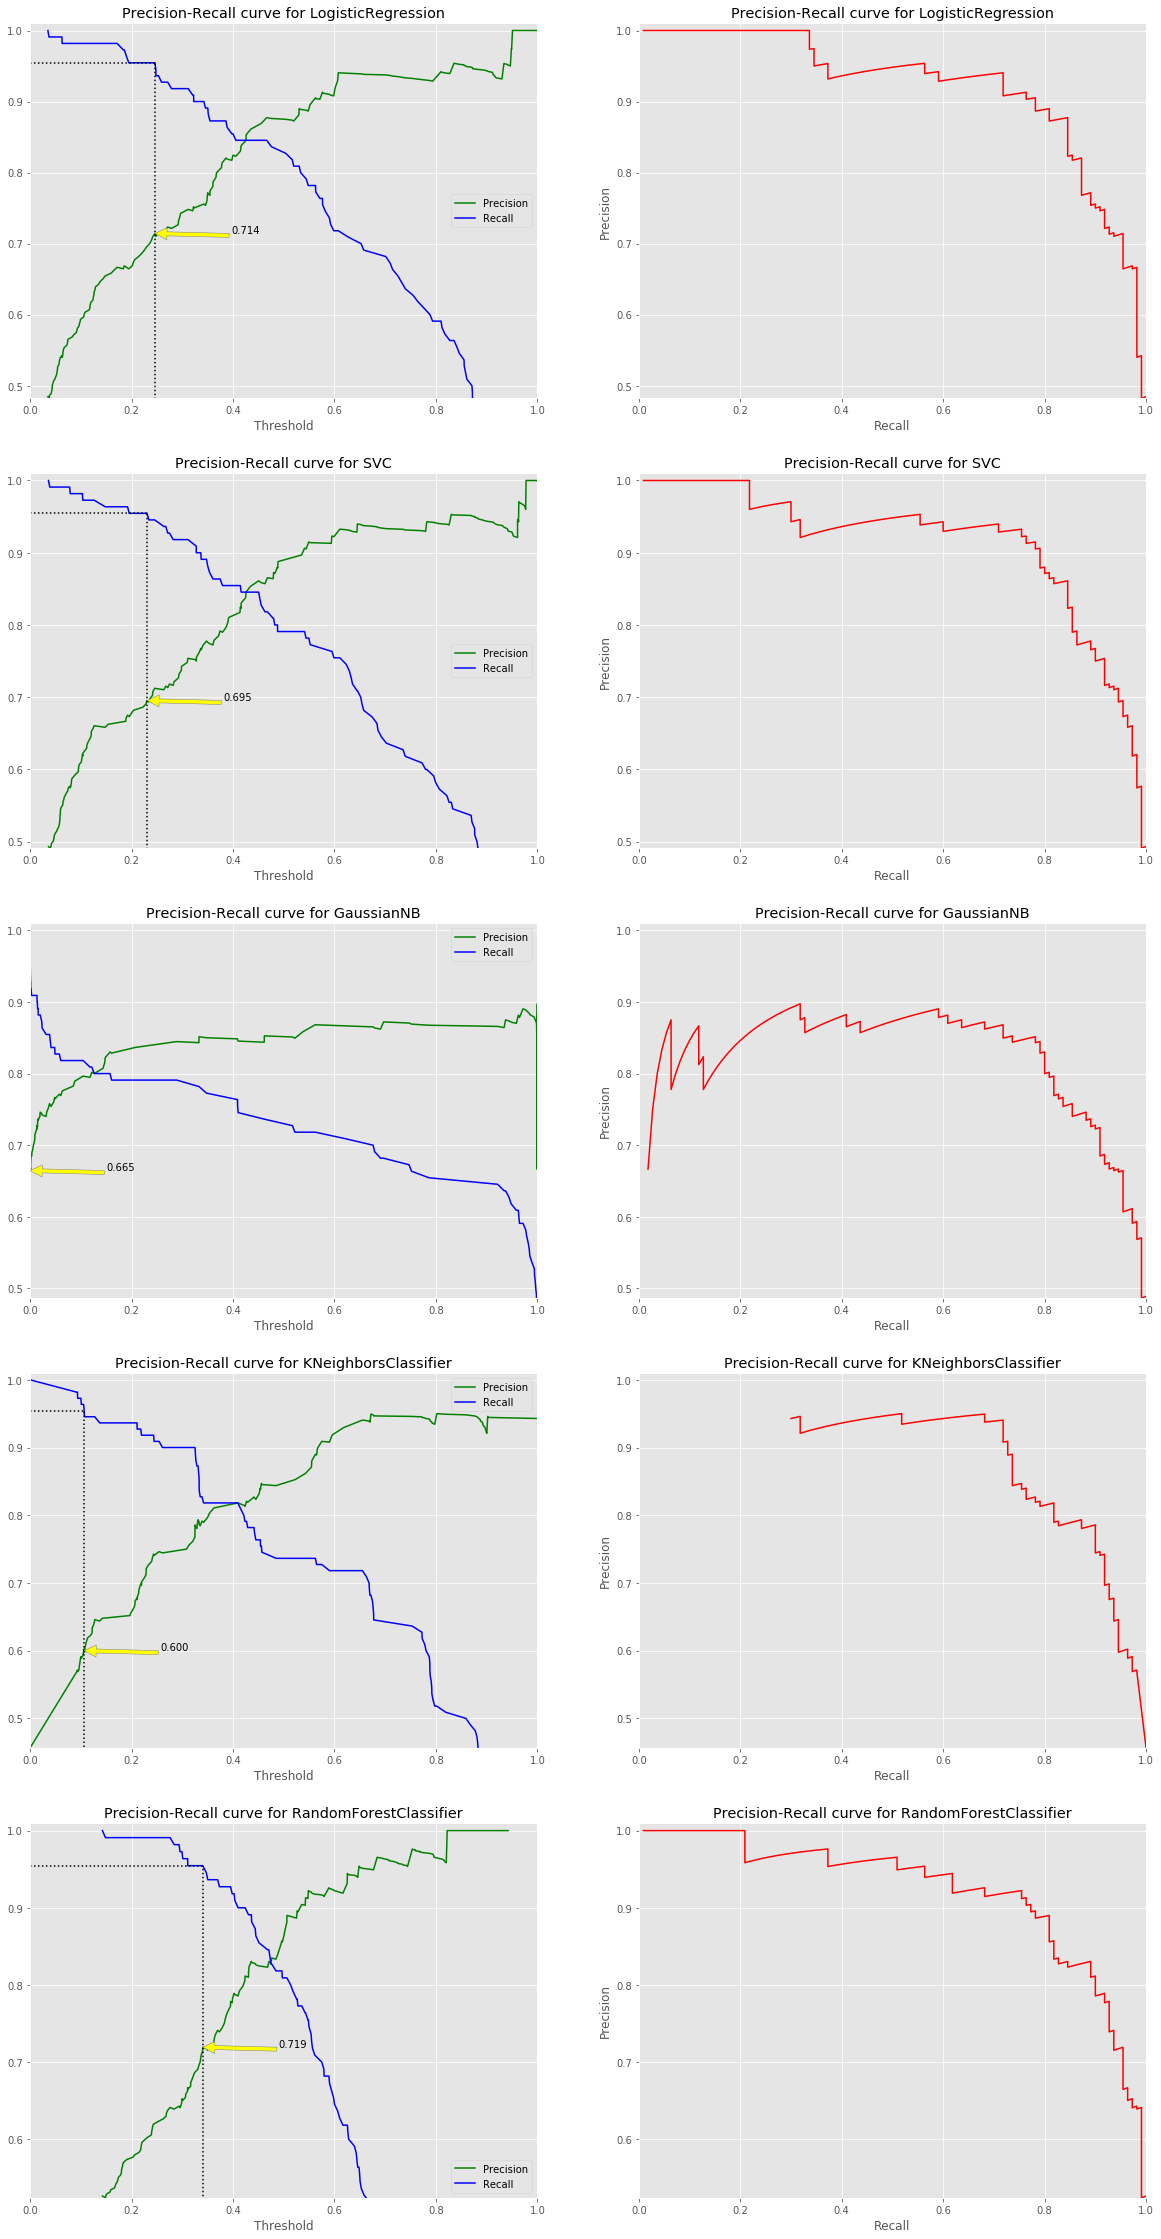

In [40]:
plot_all_precision_recall_curves(classifiers, precision, recall, threshold)

plt.show()

To improve variance, we are going to use bagging on each bagging.


In [41]:
from sklearn.ensemble import BaggingClassifier
 
classifiers_bagged = {}
for clf in classifiers.keys():
    print(clf)
    classifiers_bagged[clf] = BaggingClassifier(base_estimator = clone(classifiers[clf]), 
                                                n_jobs = -1, random_state = random_state,
                                               n_estimators = 10)
    classifiers_bagged[clf].fit(X_train_processed[clf],y_train)
    profile_clf(X_train_processed[clf],y_train, clf = classifiers_bagged[clf], 
                cv = cv, train_scorer = 'roc_auc', scoring = scoring)
    print(20*'-')

Logistic Regression
roc_auc on the training set : 0.9484385843164469
Area under ROC  calculated via 5-fold cross-validation:0.933(+/-0.064)
Accuracy  calculated via 5-fold cross-validation:0.855(+/-0.108)
Recall  calculated via 5-fold cross-validation:0.791(+/-0.178)
Precision  calculated via 5-fold cross-validation:0.878(+/-0.101)
--------------------
SVM
roc_auc on the training set : 0.9482997918112421
Area under ROC  calculated via 5-fold cross-validation:0.932(+/-0.066)
Accuracy  calculated via 5-fold cross-validation:0.855(+/-0.094)
Recall  calculated via 5-fold cross-validation:0.782(+/-0.134)
Precision  calculated via 5-fold cross-validation:0.887(+/-0.112)
--------------------
Naive Bayes
roc_auc on the training set : 0.9221374045801527
Area under ROC  calculated via 5-fold cross-validation:0.910(+/-0.079)
Accuracy  calculated via 5-fold cross-validation:0.830(+/-0.119)
Recall  calculated via 5-fold cross-validation:0.745(+/-0.187)
Precision  calculated via 5-fold cross-validat

In [42]:
filename = r'classifiers\classifiers_bagged.pkl'


In [43]:
with open(filename, 'wb') as f:
    pickle.dump(classifiers_bagged, f)


In [44]:
classifiers_bagged = pickle.load(open(filename, 'rb'))


In [45]:
y_scores_bagged = {}
for clf in classifiers_bagged.keys():
    y_scores_bagged[clf] = cross_val_predict(classifiers_bagged[clf], X_train_processed[clf], y_train, 
                                             cv=cv, method = 'predict_proba')[:,1]


In [46]:
precision, recall, threshold = {}, {}, {}
for clf in classifiers_bagged.keys():
    precision[clf], recall[clf], threshold[clf] = precision_recall_curve(y_train, y_scores_bagged[clf])


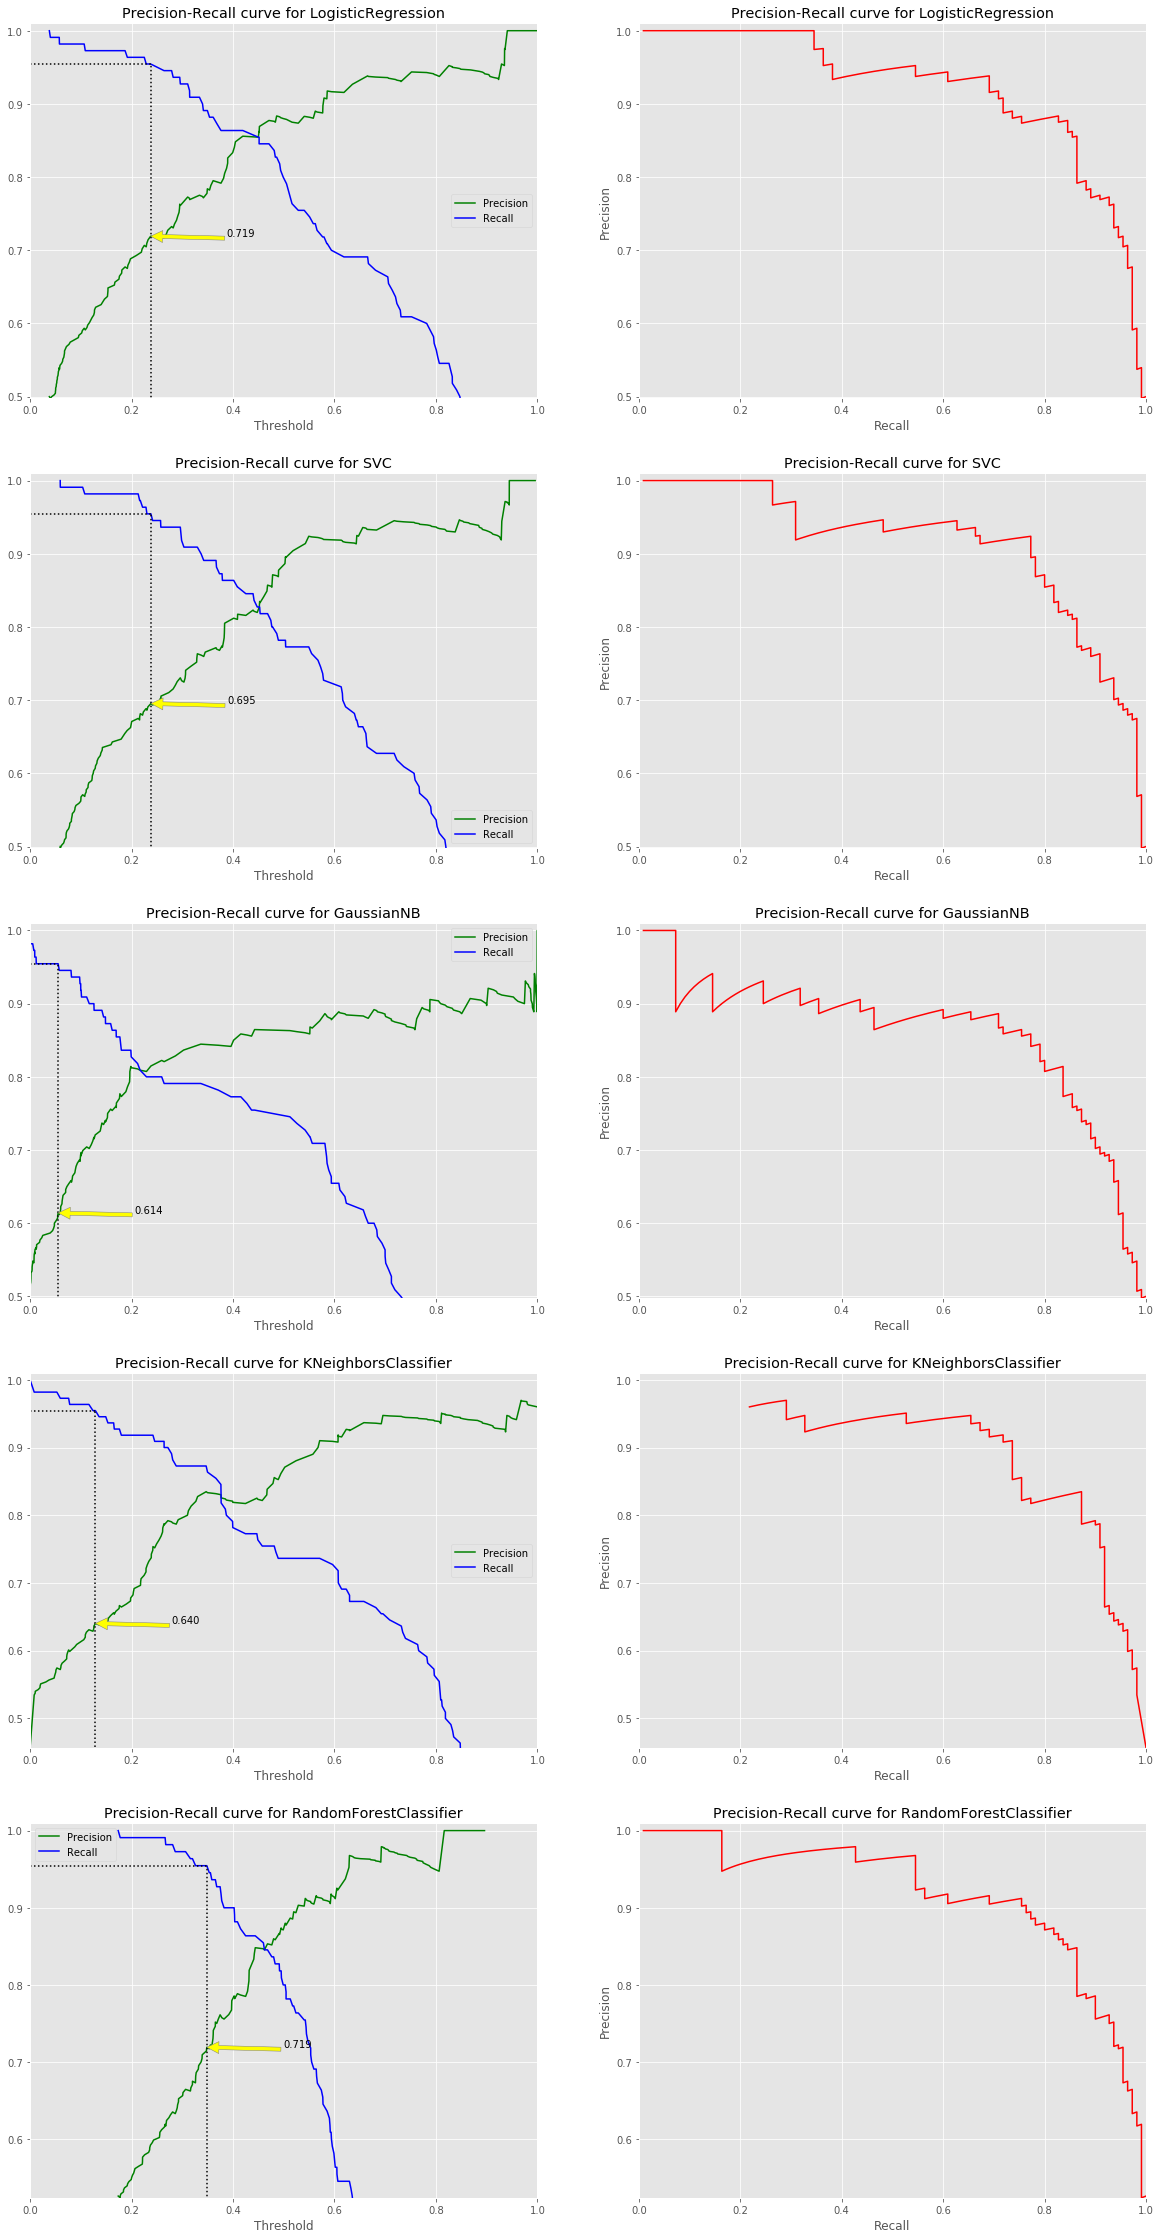

In [47]:
plot_all_precision_recall_curves(classifiers_bagged, precision, recall, threshold)
plt.savefig(img_path + r'\all_precision_recall_curves.png')
plt.show()

In [48]:
threshold_95 = {}
for clf in classifiers_bagged.keys():
    threshold_95[clf] = threshold[clf][len(recall[clf][recall[clf] >=0.95]) -1]


In [49]:
#Set the prediction = 1 if the probability is above the specified threshold, and 0 otherwise.
y_pred = {}
for clf in classifiers_bagged.keys():
        y_pred[clf] = (cross_val_predict(classifiers_bagged[clf], X_train_processed[clf], y_train, n_jobs = -1, 
                                         cv=cv, method = 'predict_proba')[:,1] >= threshold_95[clf]).astype(int)


In [50]:
for clf in classifiers.keys():
    print(clf)
    print('Accuracy:', accuracy_score(y_train, y_pred[clf]))
    print('Precision:', precision_score(y_train, y_pred[clf]))
    print('Recall:', recall_score(y_train, y_pred[clf]))
    print(20*'-')

Logistic Regression
Accuracy: 0.8091286307053942
Precision: 0.7191780821917808
Recall: 0.9545454545454546
--------------------
SVM
Accuracy: 0.7883817427385892
Precision: 0.695364238410596
Recall: 0.9545454545454546
--------------------
Naive Bayes
Accuracy: 0.7053941908713693
Precision: 0.6140350877192983
Recall: 0.9545454545454546
--------------------
K-Nearest Neighbours
Accuracy: 0.7344398340248963
Precision: 0.6402439024390244
Recall: 0.9545454545454546
--------------------
Random Forest
Accuracy: 0.8091286307053942
Precision: 0.7191780821917808
Recall: 0.9545454545454546
--------------------


The random forest and logistic regression models now stand out as the best choices. A precision of ~72% at a recall level of 95% is very good for our purposes.We will perform some error analysis to see if we can improve the performance further.
	

## Error analysis

We will visualise the data to get a feel for what sort of points are being misclassified by the different classifiers.
Since the naive Bayes classifier performs significantly worse than the others, we will remove it from the rest of the analysis

In [51]:
new_classifiers_bagged = classifiers_bagged
del new_classifiers_bagged['Naive Bayes']

In [52]:
df_train = pd.DataFrame(X_train.copy(), columns = encoded_features)
df_train['target'] = np.array(y_train.copy())

In [53]:
for clf in new_classifiers_bagged.keys():
    df_train[f'{clf} prediction'] = y_pred[clf] 
#     df_train[f'{clf} confidence'] = [np.NaN for i in range(len(df_train[f'{clf} prediction']))]
#     df_train[f'{clf} confidence'][ df_train[f'{clf} prediction'] == 0 ] = cross_val_predict(classifiers_bagged[clf], X_train_processed[clf], y_train, cv = cv, n_jobs = -1, method = 'predict_proba')[:,0]
#     df_train[f'{clf} confidence'][ df_train[f'{clf} prediction'] == 1 ] = cross_val_predict(classifiers_bagged[clf], X_train_processed[clf], y_train, cv = cv, n_jobs = -1, method = 'predict_proba')[:,1]


In [54]:
data = {} 
for clf in new_classifiers_bagged.keys():
    data[clf] = np.array(df_train[f'{clf} prediction'])
df_train['total'] = pd.DataFrame(data).sum(axis = 1)


In [55]:
df_train_misclassified = {}
df_train_classified = {}
for clf in new_classifiers_bagged.keys():
    df_train_misclassified[clf] = df_train[ df_train['target'] != df_train[f'{clf} prediction'] ].copy()
    df_train_classified[clf] = df_train[ df_train['target'] == df_train[f'{clf} prediction'] ].copy()
    

In [56]:
misclassified_description = pd.DataFrame()

In [57]:
for clf in new_classifiers_bagged.keys():
    misclassified_description[clf] = df_train_misclassified[clf].describe().loc['mean']
    
misclassified_description[:len(encoded_features)]


,Logistic Regression,SVM,K-Nearest Neighbours,Random Forest
age,55.586957,54.941176,57.062500,55.934783
resting blood pressure,131.152174,132.450980,131.343750,128.934783
cholesterol,252.217391,243.941176,243.203125,242.739130
max heart rate,150.608696,153.588235,150.796875,148.956522
ST depression (ecg),0.826087,0.778431,0.673438,0.741304
major vessels,0.521739,0.549020,0.484375,0.478261
sex,0.760870,0.803922,0.671875,0.760870
exercise induced angina,0.260870,0.235294,0.234375,0.282609
fasting blood sugar > 120 mg/dl,0.173913,0.196078,0.218750,0.152174
asymptomatic cp,0.413043,0.392157,0.343750,0.391304


A quick look at this table suggests that the classifiers are all misclassifying different data points.

In [58]:
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train_prepped)

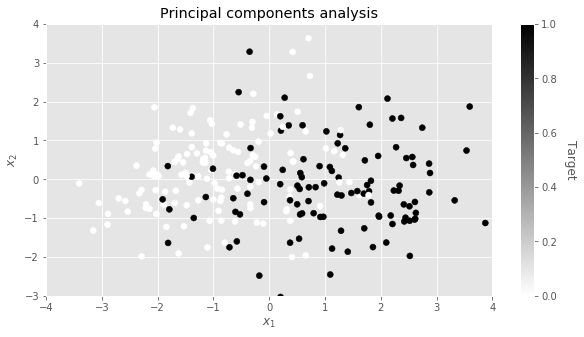

In [59]:
fig = plt.figure(figsize = (10,5))
ax1 = plt.subplot(111)

im = ax1.scatter(X_train_pca[:,0], X_train_pca[:,1], 
            c =y_train, cmap = plt.cm.binary)
cb = plt.colorbar(im)    
cb.set_label('Target', rotation = 270, labelpad = 20)
plt.title('Principal components analysis')
plt.axis([-4,4,-3,4])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(img_path + r'\pca_plot.png')
plt.show()

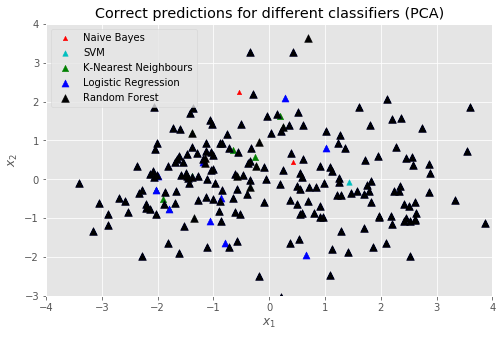

In [60]:
fig = plt.figure(figsize = (8,5))
ax1 = plt.subplot(111)
i = 0
size = 20

colours = ['r', 'c', 'g', 'b', 'k']
for clf in ['Naive Bayes', 'SVM','K-Nearest Neighbours', 
            'Logistic Regression', 'Random Forest']:

    xs = X_train_pca[:,0][y_train == y_pred[clf]]
    ys = X_train_pca[:,1][y_train == y_pred[clf]]

    im = ax1.scatter(xs, ys, color = colours[i],marker = '^',
            label = clf, s = size)
    size += 10
    i+=1
    
plt.axis([-4,4,-3,4])
plt.legend()
plt.title('Correct predictions for different classifiers (PCA)')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(img_path + r'\pca_correct_predictions.png')
plt.show()


The above plot shows the additional correct predictions that could be made by combining the random forest with the other classifiers. 

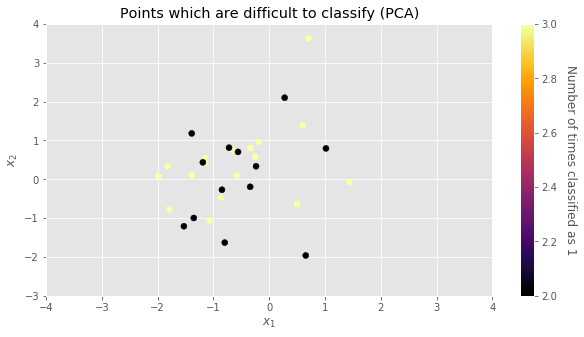

In [61]:
fig = plt.figure(figsize = (10, 5))
ax1 = plt.subplot(111)

xs = X_train_pca[:,0][(2 <= df_train['total']) & (df_train['total'] <=3)]
ys = X_train_pca[:,1][(2 <= df_train['total']) & (df_train['total'] <=3)]



im = ax1.scatter(xs, ys, c = df_train['total'][(2 <= df_train['total']) & (df_train['total'] <=3)], cmap = plt.cm.inferno)

cb = plt.colorbar(im)
cb.set_label('Number of times classified as 1', rotation = 270, labelpad = 20)
plt.title('Points which are difficult to classify (PCA)')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.savefig(img_path + r'\pca_difficult_points.png')
plt.axis([-4,4,-3,4])
plt.show()


This graph tries to capture which points the classifiers find hard to deal with by looking at those points on which there is a 2:3 split of the votes between the classifiers. We notice that none of these points are to the right of $x_1 = 1$, which is just a product of us prioritising recall. It is of no real surprise then that the difficult points to classify are those which lie in the zone with a higher density of points with target = 0 and still a significant number of target = 1 points. 

We will try to use a locally linear embedding instead of PCA to see if that makes things more clear.

In [62]:
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 8, 
                             random_state = random_state, reg = 0.1)
X_train_lle = lle.fit_transform(X_train_prepped)

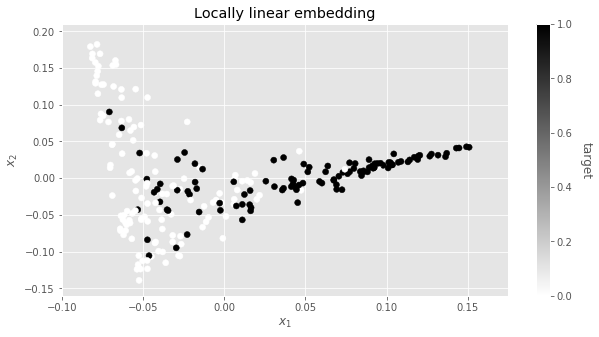

In [63]:
fig = plt.figure(figsize = (10,5))
ax1 = plt.subplot(111)



im = ax1.scatter(X_train_lle[:,0], X_train_lle[:,1], 
            c =y_train, cmap = plt.cm.binary, alpha = 1)
plt.axis([-0.1, 0.175, -0.16, 0.21])
cb = plt.colorbar(im)    
cb.set_label('target', rotation = 270, labelpad = 20)
plt.title('Locally linear embedding')
plt.savefig(img_path + r'\lle_plot.png')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

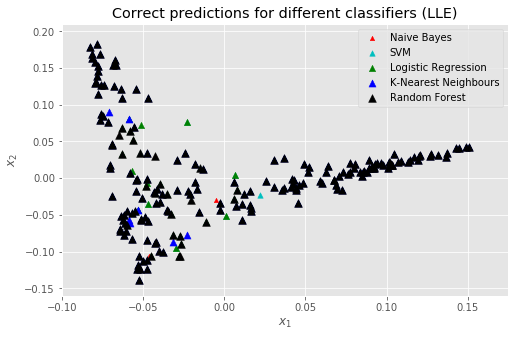

In [64]:
fig = plt.figure(figsize = (8,5))
ax1 = plt.subplot(111)
i = 0
size = 20

colours = ['r', 'c', 'g', 'b', 'k']
for clf in ['Naive Bayes', 'SVM', 
            'Logistic Regression','K-Nearest Neighbours', 'Random Forest']:

    xs = X_train_lle[:,0][y_train == y_pred[clf]]
    ys = X_train_lle[:,1][y_train == y_pred[clf]]

    im = ax1.scatter(xs, ys, color = colours[i],marker = '^',
            label = clf, s = size)
    size += 10
    i+=1

plt.legend()
plt.axis([-0.1, 0.175, -0.16, 0.21])
plt.title('Correct predictions for different classifiers (LLE)')
plt.savefig(img_path + r'\lle_correct_predictions.png')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

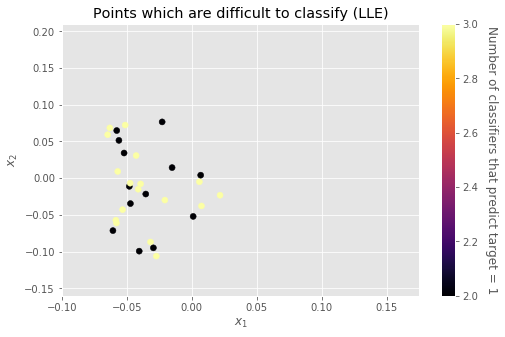

In [65]:
fig = plt.figure(figsize = (8, 5))
ax1 = plt.subplot(111)

xs = X_train_lle[:,0][(2 <= df_train['total']) & (df_train['total'] <=3)]
ys = X_train_lle[:,1][(2 <= df_train['total']) & (df_train['total'] <=3)]

im = ax1.scatter(xs, ys, c = df_train['total'][(2 <= df_train['total']) & (df_train['total'] <=3)], cmap = plt.cm.inferno)

cb = plt.colorbar(im)
cb.set_label('Number of classifiers that predict target = 1', rotation = 270, labelpad = 20)
plt.title('Points which are difficult to classify (LLE)')
plt.savefig(img_path + r'\lle_difficult_points.png')
plt.axis([-0.1, 0.175, -0.16, 0.21])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()


Again, we see much the same phenomena in terms of which points are difficult to classify.

In [66]:
hard_points = X_train[(2<= df_train['total']) & (df_train['total'] <=3)]

In [67]:
hard_points_df = pd.DataFrame(hard_points, columns = encoded_features)

In [68]:
hard_points_df.describe()

,age,resting blood pressure,cholesterol,max heart rate,ST depression (ecg),major vessels,sex,exercise induced angina,fasting blood sugar > 120 mg/dl,asymptomatic cp,...,typical angina cp,abnormal ecg,left ventricular hypertrophy (ecg),normal ecg,downsloping,flat,upsloping,fixed thal,no thal,reversable thal
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.0,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,53.300000,130.400000,246.233333,158.866667,0.773333,0.566667,0.766667,0.133333,0.266667,0.300000,...,0.066667,0.0,0.366667,0.633333,0.100000,0.266667,0.633333,0.033333,0.700000,0.266667
std,8.917824,16.042186,57.304199,19.074687,0.881196,0.817200,0.430183,0.345746,0.449776,0.466092,...,0.253708,0.0,0.490133,0.490133,0.305129,0.449776,0.490133,0.182574,0.466092,0.449776
min,40.000000,100.000000,126.000000,114.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.250000,120.000000,203.250000,145.250000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,52.000000,130.000000,246.500000,162.000000,0.450000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,57.750000,140.000000,272.000000,173.000000,1.350000,1.000000,1.000000,0.000000,0.750000,1.000000,...,0.000000,0.0,1.000000,1.000000,0.000000,0.750000,1.000000,0.000000,1.000000,0.750000
max,74.000000,172.000000,417.000000,186.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [69]:
df_train.describe()

,age,resting blood pressure,cholesterol,max heart rate,ST depression (ecg),major vessels,sex,exercise induced angina,fasting blood sugar > 120 mg/dl,asymptomatic cp,...,upsloping,fixed thal,no thal,reversable thal,target,Logistic Regression prediction,SVM prediction,K-Nearest Neighbours prediction,Random Forest prediction,total
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,...,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000
mean,54.253112,131.269710,243.369295,149.618257,1.020747,0.717842,0.688797,0.319502,0.153527,0.473029,...,0.473029,0.066390,0.556017,0.377593,0.456432,0.605809,0.626556,0.680498,0.605809,2.518672
std,9.031786,16.968533,47.949545,23.467786,1.168325,0.954841,0.463949,0.467254,0.361245,0.500311,...,0.500311,0.249481,0.497886,0.485794,0.499135,0.489693,0.484725,0.467254,0.489693,1.758510
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,120.000000,211.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,130.000000,239.000000,152.000000,0.600000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,4.000000
75%,61.000000,140.000000,271.000000,168.000000,1.600000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000
max,77.000000,200.000000,417.000000,202.000000,6.200000,3.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


Inspecting these two tables sided by side, we see that points we are looking at seem to come from a very similar distribution to the overall training data, and so it is difficult to see a clear path to improving the performance of the classifiers.  

So we have a classifier which performs very well on the training set under cross-validation, and there are no obvious ways to improve it via error analysis. It's time to estimate how this classifier will do on new data.

# Ensembling 

In [70]:
class ThresholdVotingClassifier(BaseEstimator, ClassifierMixin):

    '''
    A voting classifier where the base estimators can have different thresholds
    and be based on different subsets of the features.
    '''


    def __init__(self,estimators,n_relevant_features = None,feature_importances = None, thresholds = None):
        self.estimators = estimators
        self.n_relevant_features = n_relevant_features
        self.thresholds = thresholds
        self.feature_importances = feature_importances
    
    #Will also need to define a custom scorer.
    
    def fit(self,X,y):
        
        if type(X) == dict:
            for clf in self.estimators.keys():
                self.estimators[clf].fit(X[clf],y)
        
#         if self.n_relevant_features is not None:
#             X_selected_features = {}
#             for clf in self.estimators.keys():
#                 attrib_remover = RedundantAttributesRemover(self.feature_importances, self.n_relevant_features[clf])
#                 X_selected_features[clf] = attrib_remover.fit_transform(X)                                                 
#                 self.estimators[clf].fit(X_selected_features[clf], y)
            
        else:
            for clf in self.estimators.keys():
                self.estimators[clf].fit(X, y) 
        
        return self
    
    def predict(self,X, y = None):
        y_pred = {}
        
        if type(X) == dict:
            X_selected_features = {}
            if self.thresholds is not None:               
                for clf in self.estimators.keys():
#                     attrib_remover = RedundantAttributesRemover(self.feature_importances, self.n_relevant_features[clf])
#                     X_selected_features[clf] = attrib_remover.fit_transform(X)
#                     y_pred[clf] = (self.estimators[clf].predict_proba(X_selected_features[clf])[:,1] 
#                                    >= self.thresholds[clf]).astype(int) 
                    y_pred[clf] = (self.estimators[clf].predict_proba(X[clf])[:,1] 
                                   >= self.thresholds[clf]).astype(int)

            else:
                for clf in self.estimators.keys():
#                     attrib_remover = RedundantAttributesRemover(self.feature_importances, self.n_relevant_features[clf])
#                     X_selected_features[clf] = attrib_remover.fit_transform(X)
#                     y_pred[clf] = self.estimators[clf].predict(self.X_selected_features[clf])
                    y_pred[clf] = self.estimators[clf].predict(X[clf])
        else:
            if self.thresholds is not None:  
                for clf in self.estimators.keys():
                    y_pred[clf] = (self.estimators[clf].predict_proba(X)[:,1] >= self.thresholds[clf]).astype(int)


            else:
                for clf in self.estimators.keys():
                    y_pred[clf] = self.estimators[clf].predict(X)

        scores = pd.DataFrame(y_pred).sum(axis = 1)
        scores = (scores >= len(self.estimators.keys())/2).astype(int)

        return np.array(scores)

# Evaluating the chosen model

In [74]:
clf = 'Random Forest'

In [75]:
#Have to remove the attributes which were unhelpful to the random forest
attrib_remover = RedundantAttributesRemover(feature_importances[clf], n_relevant_features[clf])
X_test_processed = attrib_remover.fit_transform(X_test_prepped)


In [76]:
y_pred = (classifiers_bagged[clf].predict_proba(X_test_processed)[:,1] >= threshold_95[clf]).astype(int)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))

Accuracy: 0.7049180327868853
Precision: 0.625
Recall: 0.8928571428571429


So the classifier still performs quite a bit worse on the test set. Due to the small size of the test set, this is a rather high-variance estimate of the effectiveness of the model. To obtain a more robust estimate for the generalisation scores, we can apply cross validation on the whole dataset. 

In [77]:
full_pipeline = Pipeline([
    ('prep_pipeline', prep_pipeline),
    ('attrib_remover', RedundantAttributesRemover(feature_importances[clf], 
                                                  n_relevant_features[clf]))
])

In [78]:
#We need re-import the original data and apply our transformations to it.
df = pd.read_excel(r'datasets\heart.xlsx')
df['target'].replace([0,1], [1,0], inplace = True)
df.drop(df[df.duplicated(keep = 'first')].index[0], inplace = True)
df = rename_columns(df)
df['major vessels'].replace([4],[0], inplace = True)
df['thalassemia'].replace([0], [2], inplace = True)

In [79]:
df = df[num_features + bin_features + cat_features + ['target']].copy()

In [80]:
X = df.drop(['target'], axis =1)
y = df['target']

In [81]:
rename_cat_values(X)

In [82]:
X_train = pd.DataFrame(X_train, columns = encoded_features)
full_pipeline.fit(X)
X_prepped = full_pipeline.fit_transform(X)

In [83]:
y_pred = (cross_val_predict(classifiers_bagged[clf], X_prepped, y, n_jobs = -1, 
                                 cv=cv, method = 'predict_proba')[:,1] >= threshold_95[clf]).astype(int)

In [84]:
print('Accuracy:', accuracy_score(y, y_pred))
print('Precision:', precision_score(y, y_pred))
print('Recall:', recall_score(y, y_pred))

Accuracy: 0.7748344370860927
Precision: 0.6923076923076923
Recall: 0.9130434782608695


So in the end a random forest model works the best after we apply bagging. When applied to unseen data, we can expect the classifier to achieve 91.3% recall at 69.2% precision. One thing to keep in mind is the distribution that this data came from. This is data based on medical patients, which in and of itself makes the people involved more likely to have heart disease. If we were to apply this model to the general public, first of all there would be the issue of many missing pieces of information (what percentage of the population have had an ecg recently?), and also there would be a much greater portion of healthy people, so there would be no reason to expect the model to generalise well in this setting.